# WWOX

WWOX encodes a 414-amino acid protein containing 2 WW domains coupled to a region with high homology to the short-chain dehydrogenase/reductase (SRD) family of enzymes.
[developmental and epileptic encephalopathy-28 (DEE28)](https://omim.org/entry/616211) and [ autosomal recessive spinocerebellar ataxia-12 (SCAR12)](https://omim.org/entry/614322) caused by biallelic mutation in the WWOX gene.

In [28]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1.dev0


### WWOX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for WWOX.

In [29]:
gene_symbol = 'WWOX'
mane_tx_id = 'NM_016373.4'
mane_protein_id = "NP_057457.1" 

In [31]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_store_release = '0.1.21'


registry = configure_phenopacket_registry()
#with registry.open_phenopacket_store(phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


from pyphetools.visualization import PhenopacketIngestor
ing = PhenopacketIngestor(indir="../../../phenopacket-store/notebooks/WWOX/phenopackets")    
phenopackets2 = ing.get_phenopacket_list()
print("Got {len(phenopackets2)}")

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets2, 
    cohort_creator=cohort_creator,
)

validation.summarize()

[pyphetools] Ingested 38 GA4GH phenopackets.
Got {len(phenopackets2)}
Individuals Processed:   0%|          | 0/38 [00:00<?, ?individuals/s]

Expected a result but got an Error for variant: 16_78386858_78386858_A_--45894bp--
<html><body><h1>400 Bad request</h1>
Your browser sent an invalid request.
</body></html>



Individuals Processed: 100%|██████████| 38/38 [00:04<00:00,  8.69individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    variants
      #0
       warnings:
       ·Individual PMID_30356099_Patient_1 has an error with variant 16_78386858_78386858_A_--45894bp--. Try again or remove variant from testing... Expected a result but got an Error. See log for details.
  patient #1
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #13
   errors:
   ·Individual PMID_25411445_Patient_1 has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    variants
      #0
       warnings:
       ·Individual PMID_25411445_Patient_1 has an error with variant SO:1000029_HGNC:12799_WWOX. Try again or remove variant from testing... 

In [32]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)


HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,36
EEG abnormality,HP:0002353,32
Epileptic encephalopathy,HP:0200134,29
Hypokinesia,HP:0002375,20
Thin corpus callosum,HP:0033725,19
Reduced eye contact,HP:0000817,19
Spasticity,HP:0001257,15
Cerebral atrophy,HP:0002059,14
Bilateral tonic-clonic seizure,HP:0002069,12
Epileptic spasm,HP:0011097,12


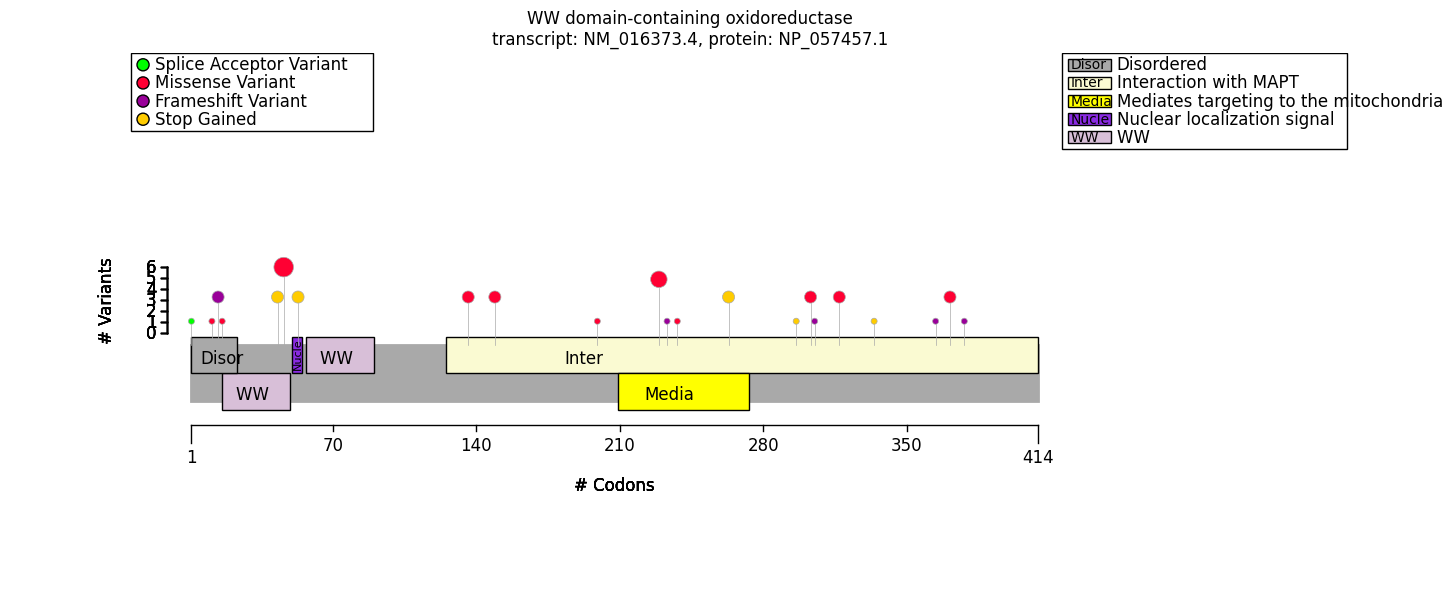

In [33]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [34]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Disordered,REGION,1 - 23,5,p.Thr12Met; p.Asp16SerfsTer63; p.Glu17Lys; p.Met1_?137
WW 1,DOMAIN,16 - 49,10,p.Met1_?137; p.Pro47Arg; p.Pro47Thr; p.Glu17Lys; p.Trp44Ter
Nuclear localization signal,MOTIF,50 - 55,3,p.Met1_?137; p.Arg54Ter
WW 2,DOMAIN,57 - 90,1,p.Met1_?137
Interaction with MAPT,REGION,125 - 414,25,p.Cys380LeufsTer149; p.His236AlafsTer34; p.Met1_?137; p.His150Pro; p.Lys297Ter; p.Ser304Tyr; p.Gln230Pro; p.Leu239Arg; p.Val365AlafsTer163; p.Arg264Ter; p.Gly137Glu; p.Lys200Glu; p.Glu306AspfsTer21; p.Ser304Phe; p.Gly372Arg; p.Trp335Ter; p.Ser318Leu
Mediates targeting to the mitochondria,REGION,209 - 273,8,p.His236AlafsTer34; p.Gln230Pro; p.Leu239Arg; p.Arg264Ter


# Genotype-Phenotype Correlation (GPC) Analysis

In [35]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [40]:

from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate
from gpsea.model import VariantEffect


is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other",
    partitions=((0,), (1,2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,8
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,52
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,136


In [25]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=fs_result)

Allele group                                       Missense/Missense          \
                                                               Count Percent   
Generalized non-motor (absence) seizure [HP:000...               2/5     40%   
Epileptic spasm [HP:0011097]                                     0/5      0%   
Round face [HP:0000311]                                          2/5     40%   
Bilateral tonic-clonic seizure with focal onset...               0/5      0%   
Narrow forehead [HP:0000341]                                     0/5      0%   
Decreased fetal movement [HP:0001558]                            0/5      0%   
Thin corpus callosum [HP:0033725]                                3/4     75%   
Abnormal corpus callosum morphology [HP:0001273]                 3/3    100%   
Abnormal cerebral morphology [HP:0002060]                        4/4    100%   
Abnormal brain morphology [HP:0012443]                           6/6    100%   
Morphological central nervous system abnormalit...               6/6    100%   
Seizure [HP:0001250]                                           11/11    100%   
Bilateral tonic-clonic seizure [HP:0002069]                      9/9    100%   
Focal clonic seizure [HP:0002266]                                1/5     20%   
Epileptic encephalopathy [HP:0200134]                            5/5    100%   
Global developmental delay [HP:0001263]                        11/11    100%   
Neurodevelopmental abnormality [HP:0012759]                    11/11    100%   
Abnormal muscle tone [HP:0003808]                                4/4    100%   
EEG abnormality [HP:0002353]                                     8/8    100%   
Upper motor neuron dysfunction [HP:0002493]                      4/4    100%   
Spasticity [HP:0001257]                                          4/6     67%   
Hypertonia [HP:0001276]                                          4/4    100%   
Cerebral atrophy [HP:0002059]                                    3/5     60%   
Hypokinesia [HP:0002375]                                         3/4     75%   
Diminished movement [HP:0002374]                                 3/3    100%   
Reduced eye contact [HP:0000817]                                 4/5     80%   
Abnormal eye contact [HP:0034435]                                4/4    100%   
Abnormal communication [HP:0034434]                              8/8    100%   
Uplifted earlobe [HP:0009909]                                    1/5     20%   
Optic atrophy [HP:0000648]                                       0/2      0%   

Allele group                                       Missense/Other OR Other/Other  \
                                                                           Count   
Generalized non-motor (absence) seizure [HP:000...                          0/17   
Epileptic spasm [HP:0011097]                                                8/17   
Round face [HP:0000311]                                                     2/14   
Bilateral tonic-clonic seizure with focal onset...                          6/18   
Narrow forehead [HP:0000341]                                                3/14   
Decreased fetal movement [HP:0001558]                                       3/14   
Thin corpus callosum [HP:0033725]                                          12/17   
Abnormal corpus callosum morphology [HP:0001273]                           12/12   
Abnormal cerebral morphology [HP:0002060]                                  14/14   
Abnormal brain morphology [HP:0012443]                                     14/14   
Morphological central nervous system abnormalit...                         14/14   
Seizure [HP:0001250]                                                       19/19   
Bilateral tonic-clonic seizure [HP:0002069]                                  8/8   
Focal clonic seizure [HP:0002266]                                           4/17   
Epileptic encephalopathy [HP:0200134]                                      19/19   
Global deve

In [39]:
from gpsea.analysis.predicate.genotype import VariantPredicates

interaction_mapt = VariantPredicates.protein_feature("Interaction with MAPT", protein_metadata=protein_meta)
mapt_predicate = biallelic_predicate(
    a_predicate=interaction_mapt,
    b_predicate=~interaction_mapt,
    a_label="MAPT Interaction",
    b_label="Other",
    partitions=((0,), (1,2,))
)
mapt_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=mapt_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mapt_result)

Allele group                                       MAPT Interaction/MAPT Interaction  \
                                                                               Count   
Uplifted earlobe [HP:0009909]                                                    4/8   
Bilateral tonic-clonic seizure with focal onset...                               0/8   
Decreased fetal movement [HP:0001558]                                            0/8   
Generalized non-motor (absence) seizure [HP:000...                               2/8   
Round face [HP:0000311]                                                          3/8   
Upslanted palpebral fissure [HP:0000582]                                         2/8   
Narrow forehead [HP:0000341]                                                     2/8   
Reduced eye contact [HP:0000817]                                                 7/8   
Thin corpus callosum [HP:0033725]                                                6/8   
Abnormal corpus callosum morphology [HP:0001273]                                 6/6   
Abnormal cerebral morphology [HP:0002060]                                        8/8   
Abnormal brain morphology [HP:0012443]                                           8/8   
Morphological central nervous system abnormalit...                               8/8   
Seizure [HP:0001250]                                                           12/12   
Bilateral tonic-clonic seizure [HP:0002069]                                      5/5   
Focal clonic seizure [HP:0002266]                                                2/8   
Motor seizure [HP:0020219]                                                       6/6   
Epileptic encephalopathy [HP:0200134]                                            9/9   
Global developmental delay [HP:0001263]                                        11/11   
Neurodevelopmental delay [HP:0012758]                                          11/11   
Neurodevelopmental abnormality [HP:0012759]                                    11/11   
Abnormal muscle tone [HP:0003808]                                                7/7   
EEG abnormality [HP:0002353]                                                     8/8   
Upper motor neuron dysfunction [HP:0002493]                                      7/7   
Spasticity [HP:0001257]                                                          7/9   
Hypertonia [HP:0001276]                                                          7/7   
Cerebral atrophy [HP:0002059]                                                    4/8   
Epileptic spasm [HP:0011097]                                                     4/9   
Hypokinesia [HP:0002375]                                                         7/8   
Diminished movement [HP:0002374]                                                 7/7   
Abnormal eye contact [HP:0034435]                                                7/7   
Abnormal communication [HP:0034434]                                              7/7   
Optic atrophy [HP:0000648]                                                       2/7   

Allele group                                                \
                                                   Percent   
Uplifted earlobe [HP:0009909]                          50%   
Bilateral tonic-clonic seizure with focal onset...      0%   
Decreased fetal movement [HP:0001558]                   0%   
Generalized non-motor (absence) seizure [HP:000...     25%   
Round face [HP:0000311]                                38%   
Upslanted palpebral fissure [HP:0000582]               25%   
Narrow forehead [HP:0000341]                           25%   
Reduced eye contact [HP:0000817]                       88%   
Thin corpus callosum [HP:0033725]                      75%   
Abnormal corpus callosum morphology [HP:0001273]      100%   
Abnormal cerebral morphology [HP:0002060]             100%   
Abnormal brain morphology [HP:0012443]                100%   
Morphological central nervous system abnormalit... 